#  Сборный проект-4
## 
Вам поручено разработать демонстрационную версию поиска изображений по запрос.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

In [1398]:
#работа выполнялась локально
#локальные версии библиотек
!pip list

Package                           Version
--------------------------------- -----------------
absl-py                           1.4.0
anyio                             3.7.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
asttokens                         2.2.1
astunparse                        1.6.3
async-lru                         2.0.4
attrs                             23.1.0
Babel                             2.12.1
backcall                          0.2.0
bcc                               0.26.0
beautifulsoup4                    4.12.2
bleach                            6.0.0
cachetools                        5.3.1
catboost                          1.2
certifi                           2023.7.22
cffi                              1.15.1
chardet                           4.0.0
charset-normalizer                3.2.0
cmake                             3.27.2
cockpit                           297
comm              

**Скачиваем и распаковываем датасет**

In [2]:
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip dsplus_integrated_project_4.zip

Archive:  dsplus_integrated_project_4.zip
   creating: to_upload/
   creating: to_upload/test_images/
  inflating: to_upload/test_images.csv  
  inflating: __MACOSX/to_upload/._test_images.csv  
  inflating: to_upload/.DS_Store     
  inflating: __MACOSX/to_upload/._.DS_Store  
  inflating: to_upload/train_dataset.csv  
  inflating: __MACOSX/to_upload/._train_dataset.csv  
  inflating: to_upload/ExpertAnnotations.tsv  
  inflating: __MACOSX/to_upload/._ExpertAnnotations.tsv  
  inflating: to_upload/CrowdAnnotations.tsv  
  inflating: __MACOSX/to_upload/._CrowdAnnotations.tsv  
   creating: to_upload/train_images/
  inflating: to_upload/test_queries.csv  
  inflating: __MACOSX/to_upload/._test_queries.csv  
  inflating: to_upload/test_images/3459871361_92d1ecda36.jpg  
  inflating: __MACOSX/to_upload/test_images/._3459871361_92d1ecda36.jpg  
  inflating: to_upload/test_images/3044745642_1d0784ff29.jpg  
  inflating: __MACOSX/to_upload/test_images/._3044745642_1d0784ff29.jpg  
  inflatin

In [23]:
!ls ./to_upload

CrowdAnnotations.tsv   test_images	test_queries.csv   train_images
ExpertAnnotations.tsv  test_images.csv	train_dataset.csv


**Данные скачаны и распакованы**

In [1270]:
#загружаем библиотеки
import os
import glob

import pandas as pd
import numpy as np
from math import ceil

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression

import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertModel
from torchmetrics import MeanSquaredError

from tqdm import tqdm

In [1271]:
#фиксируем константы для псеводслучайных систем
np.random.seed(54321);
torch.manual_seed(54321);

## 1. Исследовательский анализ данных

**В этом разделе загрузим исходные данные по оценкам описаний изображений и сформируем интегральные оценки для них**

In [1273]:
df_expert = pd.read_csv('./to_upload/ExpertAnnotations.tsv', sep= '\t', header = None)
df_crowd = pd.read_csv('./to_upload/CrowdAnnotations.tsv', sep= '\t', header = None)

In [1274]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [1278]:
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [1279]:
df_expert.columns = ['image', 'id', 'e1','e2','e3']

"Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью."

In [1281]:
df_expert.head(5)

,image,id,e1,e2,e3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


Данные выглядят согласно описанию. Обработаем данные экспертов - оценку возьмем по медиане, а большой разброс посмоторим по стандартному отклонению.

In [1282]:
def e_ratio(row):
    #print(row)
    ratio = (np.median( [row['e1'] , row['e2'],  row['e3']]) - 1)/3
    std = np.std( [row['e1'] , row['e2'],  row['e3']])
    return(ratio, std)
    #return 0, 0

In [1283]:
df_expert['e_ratio'], df_expert['e_std'] = zip(*df_expert.apply(e_ratio, axis=1))

In [1284]:
df_expert[df_expert.e_std >1]

,image,id,e1,e2,e3,e_ratio,e_std
3956,3388330419_85d72f7cda.jpg,3358558292_6ab14193ed.jpg#2,1,2,4,0.333333,1.247219
5561,542179694_e170e9e465.jpg,300577375_26cc2773a1.jpg#2,1,2,4,0.333333,1.247219
5573,542317719_ed4dd95dc2.jpg,542317719_ed4dd95dc2.jpg#2,1,4,4,1.000000,1.414214


строчки 3956, 5561 - смело удаляем, 5573 - скорее всего речь идет о технической ошибке - считаем что одинаковая оценка двух экспертов достаточный аргумент.

In [1285]:
df_expert_c = df_expert.drop([3956, 5561])

Изучим оценки по краудсорсингу

In [1287]:
df_crowd.columns = ['image', 'id', 'c_ratio','yes_num','no_num']

In [1288]:
df_crowd.head(5)

,image,id,c_ratio,yes_num,no_num
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


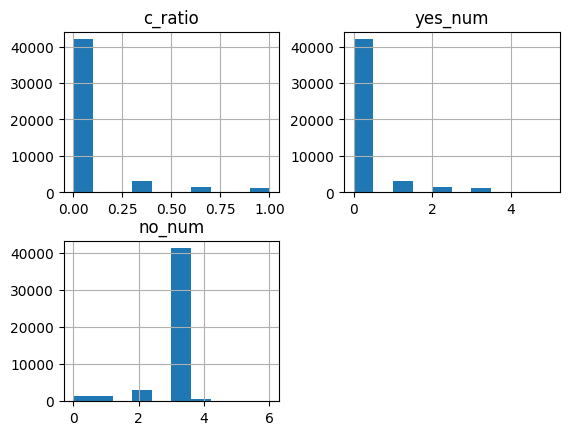

In [1289]:
df_crowd.hist(bins = 10);

In [1290]:
df_crowd[(df_crowd.no_num == 0 ) & (df_crowd.yes_num == 0)]

,image,id,c_ratio,yes_num,no_num


Данные похожи на документацию. Объединим их для построения единой таблицы и сгенерим интегральную оценку точности описания

In [1291]:
df_expert.duplicated(subset = ['id']).sum()

4845

In [1292]:
df_crowd.duplicated(subset = ['id']).sum()

46830

многие описания оценены несколько раз

In [1293]:
df_all = df_crowd.merge(df_expert_c, left_on = ['image','id'], right_on = ['image','id'], how = 'outer', indicator = True)

In [1294]:
df_all.loc[df_all['_merge']=='left_only', 'ratio'] =df_all[df_all['_merge']=='left_only']['c_ratio']

In [1295]:
df_all.loc[df_all['_merge']=='right_only', 'ratio'] =df_all[df_all['_merge']=='right_only']['e_ratio']

In [1296]:
df_all.loc[df_all['_merge']=='both', 'ratio'] =df_all[df_all['_merge']=='both']['e_ratio'] *0.6 + df_all[df_all['_merge']=='both']['c_ratio'] * 0.4

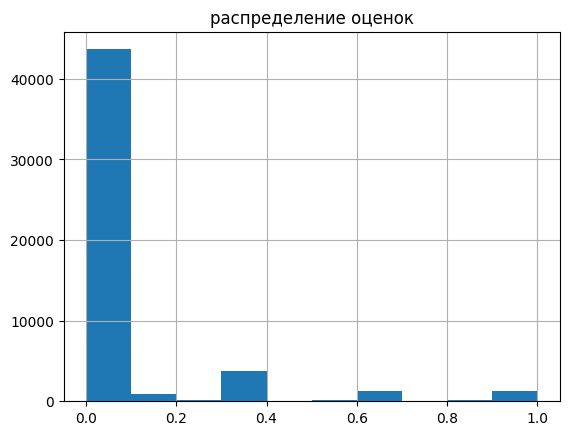

In [1307]:
df_all.ratio.hist();
plt.title("распределение оценок");

*распределение оценок носит очень плохой характер. На практике я бы избежал работы с такими данными*

Объединим датасет из имен файлов изображений, описаний и оценки соответствия

In [1298]:
df_final = df_all[['image', 'id', 'ratio']]

In [1299]:
!ls ./to_upload/

CrowdAnnotations.tsv   test_images	test_queries.csv   train_images
ExpertAnnotations.tsv  test_images.csv	train_dataset.csv


In [1300]:
df_train = pd.read_csv('./to_upload/train_dataset.csv')

In [1301]:
df_train = df_train.merge(df_final, left_on = ['image','query_id'], right_on = ['image','id'], how = 'inner', indicator = True)

In [1302]:
df_train = df_train[['image', 'query_text', 'ratio']]

In [1303]:
df_train.head(5)

,image,query_text,ratio
0,1056338697_4f7d7ce270.jpg,A young child is wearing blue goggles and sitt...,0.0
1,1262583859_653f1469a9.jpg,A young child is wearing blue goggles and sitt...,0.0
2,2447284966_d6bbdb4b6e.jpg,A young child is wearing blue goggles and sitt...,0.2
3,2549968784_39bfbe44f9.jpg,A young child is wearing blue goggles and sitt...,1.0
4,2621415349_ef1a7e73be.jpg,A young child is wearing blue goggles and sitt...,0.0


In [1304]:
df_train.duplicated(subset=['image','query_text']).sum()

0

Дубликатов нет. Данные подготовлены.

**Что касается обещей оценки исходных данных**

Анализ данных показал, что почти все оценки описаний носят негативный характер - то есть мы имеем изображения и несоответствующии им описания. На практике стоило иметь более сбалансированный датасет. Интуитивно кажется, что ничего рабочего из этих данных не выйдет. тем не менее мы собрали набор изображений, описаний и показателя соответствия описания изображению.

## 2. Проверка данных

In [1308]:
LIMIT_WORDS =  [ "boy", "boys",
    "girl",
    "child",
    "baby",
    "babies",
    "kid",
    "babe",
    "infant",
    "teenager",
    'teenage',
    "teeny",
    "juvenile",
    "teener",
    "young", 
    "younger",  
    "youngest", 
    "youngster",
    "stripling",
    "schoolchild",
    "schoolboy",
    "schoolgirl",
    "toddler",
    "toddlers" ]
LIMIT_WORDS_SET = set(LIMIT_WORDS)

In [1309]:
def check_words(descr):
    descr_set = set(descr.split())
    return(len(descr_set.intersection(LIMIT_WORDS_SET)))

In [1310]:
df_train['kid_warning'] = df_train.query_text.apply(check_words)

In [1311]:
df_train

,image,query_text,ratio,kid_warning
0,1056338697_4f7d7ce270.jpg,A young child is wearing blue goggles and sitt...,0.000000,2
1,1262583859_653f1469a9.jpg,A young child is wearing blue goggles and sitt...,0.000000,2
2,2447284966_d6bbdb4b6e.jpg,A young child is wearing blue goggles and sitt...,0.200000,2
3,2549968784_39bfbe44f9.jpg,A young child is wearing blue goggles and sitt...,1.000000,2
4,2621415349_ef1a7e73be.jpg,A young child is wearing blue goggles and sitt...,0.000000,2
...,...,...,...,...
5815,757046028_ff5999f91b.jpg,A man in an ampitheater talking to a boy .,0.333333,1
5816,799486353_f665d7b0f0.jpg,a old man walks down the uncrowded road .,0.000000,0
5817,909808296_23c427022d.jpg,A dog stands on the side of a grassy cliff .,0.333333,0
5818,929679367_ff8c7df2ee.jpg,A blurry photo of two dogs .,0.400000,0


Снижаем риски и убираем там где правдивость описания просто больше 0

In [1312]:
len(df_train[(df_train.kid_warning >0) & (df_train.ratio > 0)])

500

Убираем 500 строк

In [1353]:
df_train_с = df_train[~((df_train.kid_warning >0) & (df_train.ratio >0))]

In [1354]:
df_train_с = df_train_с.reset_index().drop(['index'],axis=1)

In [1355]:
df_train_с.shape

(5320, 4)

In [1356]:
df_train_с.head(5)

,image,query_text,ratio,kid_warning
0,1056338697_4f7d7ce270.jpg,A young child is wearing blue goggles and sitt...,0.0,2
1,1262583859_653f1469a9.jpg,A young child is wearing blue goggles and sitt...,0.0,2
2,2621415349_ef1a7e73be.jpg,A young child is wearing blue goggles and sitt...,0.0,2
3,3155451946_c0862c70cb.jpg,A young child is wearing blue goggles and sitt...,0.0,2
4,3222041930_f642f49d28.jpg,A young child is wearing blue goggles and sitt...,0.0,2


Проведена проверка данных. Удалены строки, в которых упоминаются дети (в разных своих проявлениях) и оценка больше нуля. Метод предложенный в задании выглядит не оцень адекватным. При этом стоит отметить, что данный подход к отсеву "детских" картинок выглядит крайне сомнителльно. Единственный способ это либо отфильтровать вручную (с привлечением сторонних ресурсов), либо сделать это с использованием уже обученных сеток (что, нарушит условия задачи). Что тут отфильтровано будет только на совести тех кто придумал этот проект.

## 3. Векторизация текстов

**Используем модель BERT для векторизации текстов**

In [1328]:
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [1329]:
def make_text_tensors(df):
    tokenized = df['query_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    batch_size = 100
    embeddings = []
    for i in notebook.tqdm(range((padded.shape[0] // batch_size) +1)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
            with torch.no_grad():
                batch_embeddings = bert_model(batch, attention_mask=attention_mask_batch)
            embeddings.append(batch_embeddings[0][:,0,:].numpy())
    return( np.concatenate(embeddings))

In [1330]:
tokenized = df_train_с['query_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

In [1331]:
batch_size = 100
embeddings = []
for i in tqdm(range((padded.shape[0] // batch_size) +1)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        with torch.no_grad():
            batch_embeddings = bert_model(batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

100%|██████████| 54/54 [00:55<00:00,  1.02s/it]


In [1332]:
text_tensors = np.concatenate(embeddings)

In [1333]:
text_vectors = pd.DataFrame(text_tensors).astype("float")
text_vectors.columns = ["t" + str(i) for i in range(text_vectors.shape[1])]
text_vectors = text_vectors.reset_index().drop(['index'], axis=1)

In [1334]:
text_vectors.shape

(5320, 768)

**Получили вектора по текстовым описаниям**

Проведена векторизация с помощью Bert - сформировано 768 признаков.

## 4. Векторизация изображений

**Для векторизации изображений будем использовать предобученную сеть resnet50**

In [1337]:
resnet = models.resnet50()
for param in resnet.parameters():
    param.requires_grad_(False) 

In [1338]:
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules) 

In [1339]:
resnet.eval();

In [1340]:
norm = transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,]) 

In [1358]:
def get_image_tensor(image_path):
    img = Image.open(image_path).convert('RGB') 
    image_tensor = preprocess(img).unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten() 
    return(pd.DataFrame([output_tensor]).astype("float"))

In [1360]:
len(df_train_с)

5320

In [1361]:
images_tensors = pd.DataFrame()
for i in tqdm(range(len(df_train_с))):
    images_tensors =  pd.concat([images_tensors, get_image_tensor('./to_upload/train_images/' + df_train_с.loc[i]['image']) ])

100%|██████████| 5320/5320 [05:10<00:00, 17.14it/s]


In [1362]:
images_tensors.columns = ["i" + str(i) for i in range(images_tensors.shape[1])]
images_vectors = images_tensors.reset_index().drop(['index'], axis=1)

In [1363]:
images_vectors.shape

(5320, 2048)

Проведена веторизация изображений - 2048 признаков, с использованием предобученной сети resnet50

## 5. Объединение векторов

In [1365]:
vectors = pd.concat([text_vectors, images_vectors], axis=1)

In [1368]:
vectors.shape

(5320, 2816)

Объеднили вектора - теперь у нас датасет с  2816 фич.

## 6. Обучение модели предсказания соответствия

**Будем обучать модель используя метрику RMSE - в силу того, что наш целевой параметр носит не дискретный характер, а вид показателя схожести.**

**Согласно рекомендации из задания разбиваем на train и test**

In [1369]:
target = df_train_с['ratio']

In [1370]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=54321)
train_indices, test_indices = next(gss.split(X=vectors , y=target, groups = df_train_с["image"].values))
X_train = vectors.loc[train_indices]
y_train = target.loc[train_indices]
X_test = vectors.loc[test_indices]
y_test = target.loc[test_indices]

**Модель линейной регресии**

In [1371]:
model1 = LinearRegression(positive=True)

In [1372]:
model1.fit(X_train, y_train)

LinearRegression(positive=True)

In [1373]:
predict = model1.predict(X_test)

In [1374]:
scaler = MinMaxScaler()
rmse_test = mean_squared_error(y_test, scaler.fit_transform(model1.predict(X_test).reshape(-1, 1)), squared=False)
print("RMSE =", "{:.4f}".format(rmse_test))

RMSE = 0.4035


**Довольно слабый результат даже для модели линейной регресии**

**Полносвязная Нейросеть**

In [1375]:
# нейросеть работает с тензорами
X_train_t = torch.FloatTensor(X_train.values)
X_test_t  = torch.FloatTensor(X_test.values)
y_train_t = torch.FloatTensor(y_train.values)
y_test_t = torch.FloatTensor(y_test.values)

In [1376]:
class model_n(nn.Module):
    def __init__(self, input_dim=n_in_neurons, num_layers=0, hidden_dim=64, output_dim=n_out_neurons, p=0.0, div=0):
            super().__init__()
            self.layers = torch.nn.Sequential()
            prev_size = input_dim
            for i in range(num_layers):
                self.layers.add_module('layer{}'.format(i), torch.nn.Linear(prev_size, hidden_dim))
                self.layers.add_module(f'batchnorm{i}', torch.nn.BatchNorm1d(hidden_dim))
                self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
                self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
                prev_size = hidden_dim
                if div!=0 and div!=1:
                    hidden_dim = hidden_dim // 2
            self.layers.add_module('classifier', torch.nn.Linear(prev_size, output_dim))
    def forward(self, x):
        return self.layers(x)

In [1377]:
    net = model_n(X_train_t.shape[1], 256, 64, 1, 0.1)
    net.train()
    batch_size=32
    num_epochs=10
    optimizer = torch.optim.Adam(net.parameters(), lr=0.000001)
    loss = nn.MSELoss()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = net.forward(X_train_t)
        loss_value = torch.sqrt(loss(preds.flatten(), y_train_t.flatten()))
        loss_value.backward()
        optimizer.step()
        if epoch % 10 == 0 or epoch == (num_epochs-1) :
            net.eval()
            print("RMSE on train:")
            print(torch.sqrt(loss(net(X_train_t).flatten(), y_train_t.flatten())).item())

    net.eval()
    print()
    print("RMSE on test:", torch.sqrt(loss(net(X_test_t).flatten(), y_test_t.flatten())).item())

RMSE on train:
0.2687249183654785
RMSE on train:
0.2686923146247864

RMSE on test: 0.2689943015575409


**Модель линейной регресии и нейросеть показывают посредственные значения метрики. Тем не менее нейросеть лучше. Будем пытаться использовать ее**

*(в процессе было испытано и построено несколько сетей, все они давали похожий результат. Эта чуть лучше других, но также дает странный результат)*

## 7.Тестирование модели

Возьмем данные для теста. Алгортим будет таким: делаем вектора для тестовых изображений. Получаем фразы для поиска, векторизуем есть.
Формируем матрицу из тестовых изображений и одной фразы для поиска и прогоняем через модель. Выбираем 5 картинок с самым большим показателем "схожести" и выводим их.

In [1390]:
!ls ./to_upload/

CrowdAnnotations.tsv   test_images	test_queries.csv   train_images
ExpertAnnotations.tsv  test_images.csv	train_dataset.csv


In [1379]:
test_q = pd.read_csv('./to_upload/test_queries.csv', sep='|')

выбираем 10 фраз для теста:

In [1380]:
test_queries = test_q['query_text'].sample(10, random_state= 0)

Список всех тестовых картинок

In [1381]:
test_images = pd.DataFrame(glob.glob('./to_upload/test_images/*.jpg'), columns = ['image'])

Векторизуем их

In [1382]:
test_images_tensors = pd.DataFrame()
for i in tqdm(range(len(test_images))):
    test_images_tensors =  pd.concat([test_images_tensors, get_image_tensor(test_images.loc[i]['image']) ])

100%|██████████| 100/100 [00:05<00:00, 18.69it/s]


In [1383]:
test_images_tensors.columns = ["i" + str(i) for i in range(test_images_tensors.shape[1])]
test_images_vectors = test_images_tensors.reset_index().drop(['index'], axis=1)

Формируем список запросов и векторизуем их.

In [1384]:
test_queries = pd.DataFrame(test_queries, columns=['query_text'])

In [1385]:
test_queries.reset_index(inplace=True)

In [1386]:
queries_tensors = make_text_tensors(test_queries)
queries_vectors = pd.DataFrame(queries_tensors).astype("float")
queries_vectors.columns = ["t" + str(i) for i in range(queries_vectors.shape[1])]
queries_vectors = queries_vectors.reset_index().drop(['index'], axis=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [1224]:
###############

Формируем показатели предсказания и выводим список из 5 изображений с максимальным показателем

In [1393]:
net.eval();

In [1388]:
def predict_images(qtext):
    text_vector_array = np.full((test_images_vectors.shape[0], 768), queries_vectors.loc[i])
    image_text_vectors = np.concatenate([test_images_vectors, text_vector_array], axis=1)
    image_text_vectors_t = torch.FloatTensor(image_text_vectors)    
    pred = net(image_text_vectors_t ).flatten()
    result_nn = pd.DataFrame(pred.detach(), columns=['rmse'])
    result_nn = result_nn.reset_index().sort_values(['rmse'], ascending = False)
    result_nn = result_nn.reset_index()
    return(result_nn)

Цикл анализа и вывода изображений, в которых запрос не содержит слов, относящихся к "детскому контенту"

A boy plays basketball .
 This image is unavailable in your country in compliance with local laws
############################################################
There are several people watching a person in the air with skies surrounded by mountains and snow .
predict= 0.077


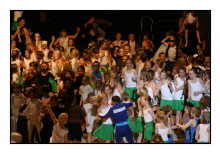

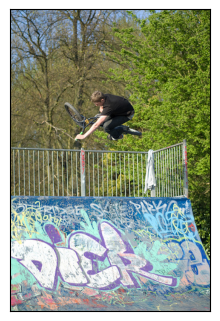

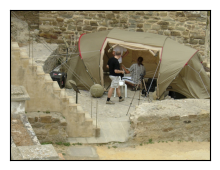

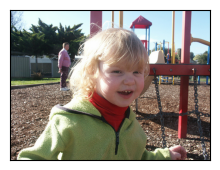

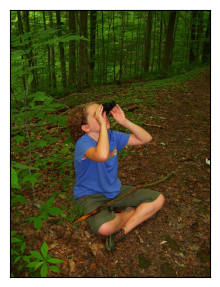

############################################################
A brown and white dog walks in the snow with a big chunk of snow in his mouth .
predict= 0.077


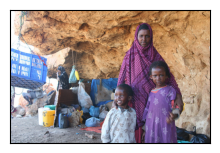

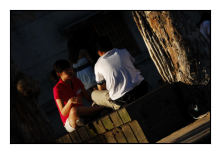

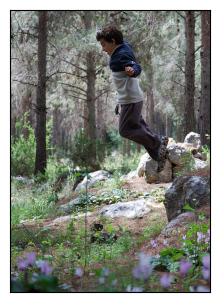

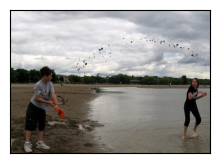

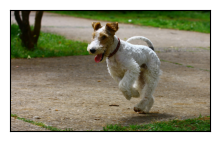

############################################################
A man and two boys standing in spraying water .
 This image is unavailable in your country in compliance with local laws
############################################################
a small shaggy dog plays with a red ball on the grass .
predict= 0.077


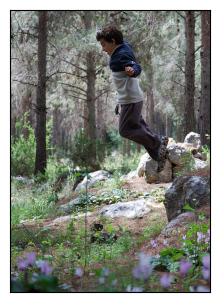

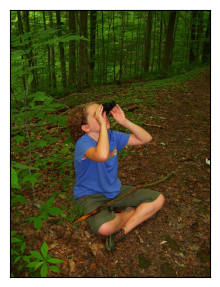

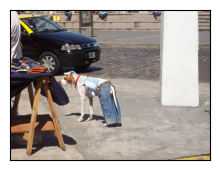

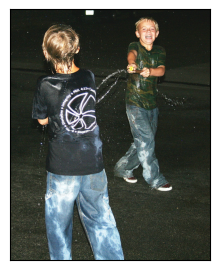

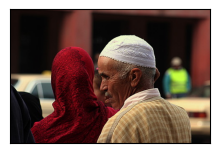

############################################################
A brown dog is sitting in some long grass .
predict= 0.077


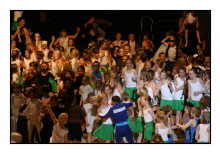

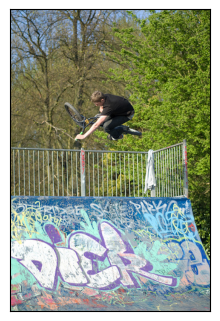

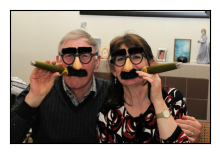

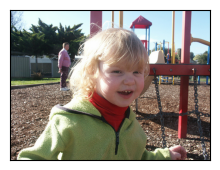

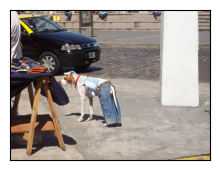

############################################################
A group of people perform together onstage .
predict= 0.077


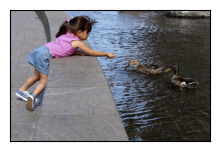

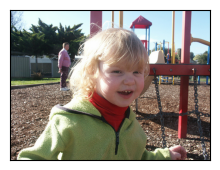

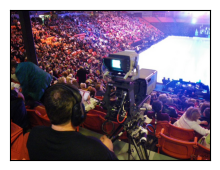

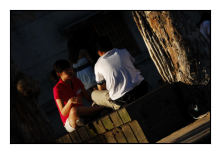

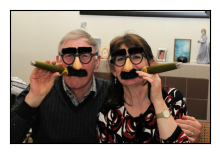

############################################################
I child slides into a wading pool full of water while an adult tosses a bucket of water on them .
 This image is unavailable in your country in compliance with local laws
############################################################
People using an outdoor ice skating rink .
predict= 0.077


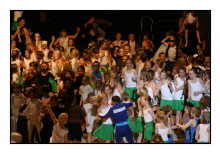

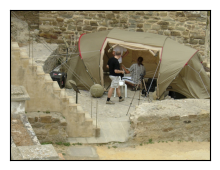

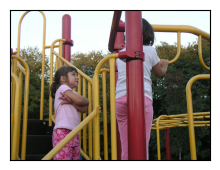

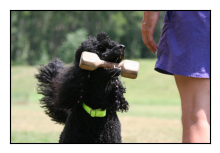

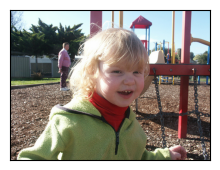

############################################################
The lady in the multi-colored shirt has a necklace on a white object in her hand .
predict= 0.077


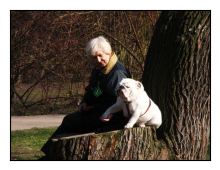

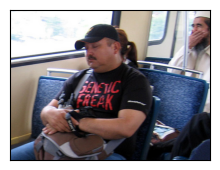

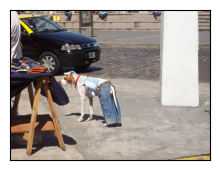

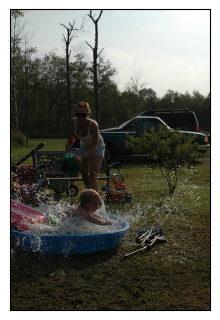

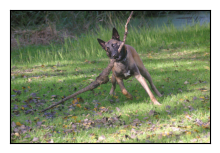

############################################################


In [1397]:
for i in range(10):
    print(test_queries.loc[i]['query_text'])
    if check_words(test_queries.loc[i]['query_text']) >0:
        print(' This image is unavailable in your country in compliance with local laws')
    else:
        result_nn = predict_images(test_queries.loc[i]['query_text'])
        print("predict=", "{:.3f}".format(result_nn.loc[0]['rmse']))
      #  display(result_nn)
        for img in range(5):
            fig = plt.figure(figsize=(15,15))
            fig.add_subplot(1,5, img+1)
            image = Image.open(test_images.loc[result_nn.loc[img]['index']]['image'])
            plt.imshow(np.array(image)) 
            plt.xticks([])
            plt.yticks([])    
           # plt.close()
            plt.show() 
    print("#"*60)

### Итак, в результате получена модель, которая по сути не работает. 

В целом формулировка задания не выглядит корректным:
1) В исходных данных очень мало изображений (недостаточно) с правильным описанием
2) Фильтрация детских фото также не выглядит логично.
3) Детские фото в тестовой выборке не отфильтрованы (это и не предлагается делать)
4) соответствие изображений на обучении и на тесте недостаточно, это касается и текстовых описаний.

Я бы предложил либо использовать уже предобученные сети для создания MVP, а потом уже уточнять, обсудив заказчиком бизнес-требования. После чего, при необходимости развивать проект.
(сталкивался, когда был спрос моделей обученных на специализированном коненте - ч\б кинохроника, анимэ и тд)